In [1]:
import pickle
import sys
import os
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats

# Fit a power law to the corrected SF
from scipy.optimize import curve_fit

sys.path.append(os.path.abspath(".."))


import src.params as params
import src.sf_funcs as sf
import src.utils as utils

# Set matplotlib font size
plt.rc("text", usetex=True)
plt.rc("font", family="serif", serif="Computer Modern", size=10)

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"


# Read in cleaned Voyager 1 data
df = pd.read_pickle("../data/interim/voyager/voyager1_lism_cleaned.pkl")
print("Loaded dataset")

# Importing lookup table
n_bins = 25
run_mode = "full"
with open(f"../results/{run_mode}/correction_lookup_3d_{n_bins}_bins_lint.pkl", "rb") as f:
    correction_lookup_3d = pickle.load(f)

# ## Computing standardised SFs
#
# i.e. from intervals of 10,000 points across 10 correlation lengths, calculated up to lag 2,000.
# Integral corr length `tc` has already been defined above.


tc = 17 * 24 * 3600  # (17 days in seconds)

tc_n = 10
interval_length = params.int_length
new_cadence = tc_n * tc / interval_length

lags = np.arange(1, params.max_lag_prop * params.int_length)
powers = [2]

Loaded dataset


In [2]:
# Extract interval up to first index + 170 days
data = df.loc[df.index[0]:df.index[0] + pd.Timedelta(days=170),:]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306001 entries, 2012-08-25 00:00:00 to 2013-02-11 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      74482 non-null  float32
 1   BR      74482 non-null  float32
 2   BT      74482 non-null  float32
 3   BN      74482 non-null  float32
dtypes: float32(4)
memory usage: 7.0 MB


In [3]:
del df

In [4]:
int_hr = data.resample("288s").mean()

In [5]:
print(new_cadence)
int_lr = data.resample(str(np.round(new_cadence, 3)) + "s").mean()

1468.8


In [6]:
del data

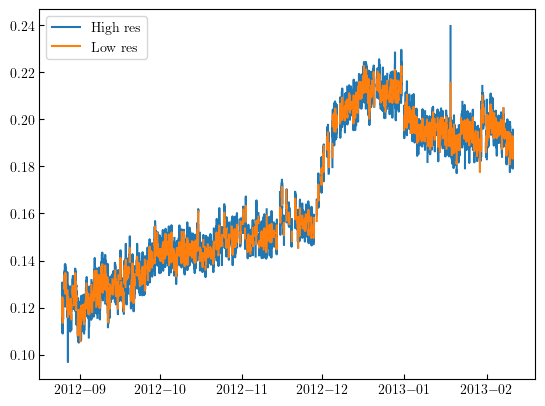

In [7]:
plt.plot(int_hr["BR"], label="High res")
plt.plot(int_lr["BR"], label="Low res")
plt.legend()

In [8]:
file_index = 0
int_index = 0

In [10]:
lags = np.arange(1, int(0.2 * len(int_lr)))

int_std = int_lr
int_norm = utils.normalize(int_std)
bad_input = int_norm[["BR", "BT", "BN"]]

bad_output = sf.compute_sf(bad_input, lags, powers, False, False)
bad_output["gap_handling"] = "naive"
bad_output["file_index"] = file_index
bad_output["int_index"] = int_index

interp_input = (
    bad_input.interpolate(method="linear").ffill().bfill()
)  # Linearly interpolate (and, in case of missing values at edges, back and forward fill)
interp_output = sf.compute_sf(interp_input, lags, powers, False, False)

interp_input_df = pd.DataFrame(interp_input)
interp_input_df.reset_index(inplace=True)  # Make time a column, not an index

interp_output["file_index"] = 0
interp_output["int_index"] = int_index
interp_output["gap_handling"] = "lint"

# Correcting sample size and uncertainty for linear interpolation, same values as no handling
interp_output["n"] = bad_output["n"]
interp_output["missing_percent"] = bad_output["missing_percent"]
interp_output["sf_2_se"] = bad_output["sf_2_se"]

sfs_gapped = pd.concat([interp_output, bad_output])

# ### Correcting SF

# ## Smoothing correction
#
# Previous method, employed in first paper submission, involved Gaussian blurring
# the heatmaps to create `correction_lookup_3d_blurred`,
# which replaced `correction_lookup_3d` in the following script.
# *See the GitHub, main branch, for this code.*
#
# This time we are smoothing the actual correction values for each specific SF;
# this is done below and applied to the interval from the paper.
#

# Apply 2D and 3D scaling to test set, report avg errors

sfs_lint_corrected_3d = sf.compute_scaling(
    sfs_gapped, 3, correction_lookup_3d, n_bins
)

from scipy.interpolate import interp1d

# Smoothing function
def smooth_scaling(x, y, num_bins=20):
    bin_edges = np.logspace(np.log10(x.min()), np.log10(x.max()), num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    y_binned = np.array(
        [
            y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])].mean()
            for i in range(len(bin_edges) - 1)
        ]
    )

    # Preserve the first and last values to prevent edge distortions
    # during extrapolation
    full_bins = np.insert(bin_centers, 0, bin_edges[0])
    full_bins = np.append(full_bins, bin_edges[-1])
    full_y_binned = np.insert(y_binned, 0, y.iloc[0])
    full_y_binned = np.append(full_y_binned, y.iloc[-1])

    interp_func = interp1d(
        full_bins, full_y_binned, kind="cubic", fill_value="extrapolate"
    )
    return interp_func(x)

single_sf = sfs_lint_corrected_3d[(sfs_lint_corrected_3d["int_index"] == int_index)]

scaling_smooth = smooth_scaling(single_sf.lag, single_sf.scaling)
scaling_lower_smooth = smooth_scaling(single_sf.lag, single_sf.scaling_lower)
scaling_upper_smooth = smooth_scaling(single_sf.lag, single_sf.scaling_upper)

# Save to the main dataframe
sfs_lint_corrected_3d.loc[
    (sfs_lint_corrected_3d["int_index"] == int_index),
    "scaling_smooth",
] = scaling_smooth

sfs_lint_corrected_3d.loc[
    (sfs_lint_corrected_3d["int_index"] == int_index),
    "scaling_lower_smooth",
] = scaling_lower_smooth

sfs_lint_corrected_3d.loc[
    (sfs_lint_corrected_3d["int_index"] == int_index),
    "scaling_upper_smooth",
] = scaling_upper_smooth

# Apply scalings
sfs_lint_corrected_3d["sf_2_corrected_3d"] = (
    sfs_lint_corrected_3d["sf_2"] * sfs_lint_corrected_3d["scaling_smooth"]
)

Loaded 3D lookup table with 25 bins


c:\Users\spann\Documents\Research\Code repos\sf_gap_analysis\src\sf_funcs.py:968: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.491909592809419' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  inputs.loc[


In [16]:
sfs_lint_corrected_3d["lag_tc"] = sfs_lint_corrected_3d["lag"] * 10 / len(int_lr)
sfs_lint_corrected_3d["res"] = "low-res"

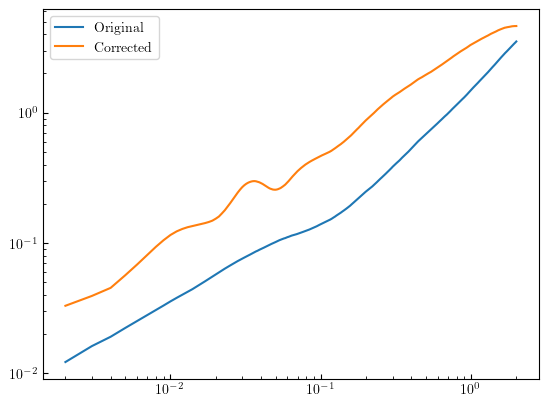

In [23]:

plt.loglog(
    sfs_lint_corrected_3d.loc[sfs_lint_corrected_3d["lag_tc"] >= 0.001, "lag_tc"],
    sfs_lint_corrected_3d.loc[sfs_lint_corrected_3d["lag_tc"] >= 0.001, "sf_2"],
    label="Original",
)
plt.loglog(
    sfs_lint_corrected_3d.loc[sfs_lint_corrected_3d["lag_tc"] >= 0.001, "lag_tc"],
    sfs_lint_corrected_3d.loc[
        sfs_lint_corrected_3d["lag_tc"] >= 0.001, "sf_2_corrected_3d"
    ],
    label="Corrected",
)
plt.legend()

LOW-RES CORRECTED (10,000 POINTS INT):

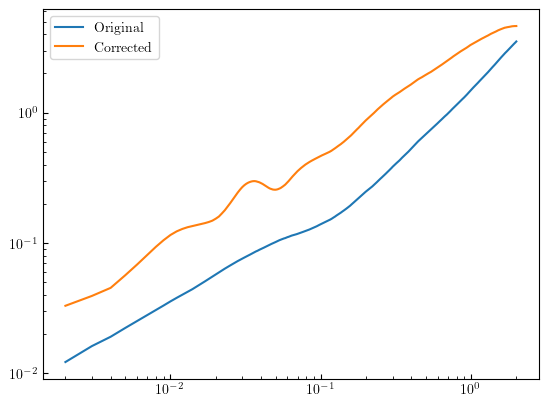

- Run the above for high-res case, making this adjustment: `correction_lookup_3d["xedges"] *`
- Compare the results